## Вариант 2: второй бэктест (много сделок)

- В расчёт включаются **все доступные экспирации** в заданном периоде, а не только один узкий интервал.
- Условия для открытия железного кондора упрощены:
  - достаточно корректных цен опционов,
  - часть греков и IV может быть с пропусками (`NaN` не блокирует сделку).
- Кондор строится каждый раз, когда на рынке есть подходящая пара call/put вокруг текущей цены базового актива.

Благодаря более мягким фильтрам и расширенному набору экспираций стратегия находит значительно больше ситуаций для входа и формирует уже **десятки сделок**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8")

FILE_PATH = "btc_options_90d_3d_window_with_greeks.csv"

INITIAL_CAPITAL = 100_000
TP_PCT = 0.25
MAX_HOURS_IN_POSITION = 4
DELTA_SHORT = 0.20
DELTA_LONG = 0.05
DELTA_STOP = 0.35
RISK_FREE_RATE = 0.03

df = pd.read_csv(FILE_PATH)

df["time"] = pd.to_datetime(df["time"], utc=True)
df["expiration"] = pd.to_datetime(df["expiration_timestamp"], utc=True)

df = df.sort_values(["instrument_name", "time"]).reset_index(drop=True)
if "delta" in df.columns:
    df["delta"] = df.groupby("instrument_name")["delta"].transform(lambda s: s.ffill().bfill())
df = df.sort_values(["expiration", "time", "instrument_name"]).reset_index(drop=True)

In [2]:
def select_iron_condor_legs(snapshot):
    snap = snapshot.copy()
    calls_all = snap[snap["option_type"] == "call"].dropna(subset=["mid_price"])
    puts_all = snap[snap["option_type"] == "put"].dropna(subset=["mid_price"])
    if calls_all.empty or puts_all.empty:
        return None

    if snap["underlying_price"].notna().any():
        under = float(snap["underlying_price"].dropna().iloc[0])
    else:
        under = float(snap["strike"].median())

    calls_delta = calls_all.dropna(subset=["delta"])
    puts_delta = puts_all.dropna(subset=["delta"])

    if len(calls_delta) >= 2 and len(puts_delta) >= 2:
        calls = calls_delta
        puts = puts_delta

        short_call_idx = (calls["delta"] - DELTA_SHORT).abs().idxmin()
        short_call = calls.loc[short_call_idx]

        long_call_candidates = calls[calls["strike"] > short_call["strike"]]
        if long_call_candidates.empty:
            long_call_candidates = calls[calls["delta"] < short_call["delta"]]
        if long_call_candidates.empty:
            return None
        long_call_idx = (long_call_candidates["delta"] - DELTA_LONG).abs().idxmin()
        long_call = long_call_candidates.loc[long_call_idx]

        short_put_idx = (puts["delta"] + DELTA_SHORT).abs().idxmin()
        short_put = puts.loc[short_put_idx]

        long_put_candidates = puts[puts["strike"] < short_put["strike"]]
        if long_put_candidates.empty:
            long_put_candidates = puts[puts["delta"] > short_put["delta"]]
        if long_put_candidates.empty:
            return None
        long_put_idx = (long_put_candidates["delta"] + DELTA_LONG).abs().idxmin()
        long_put = long_put_candidates.loc[long_put_idx]
    else:
        calls = calls_all.copy()
        puts = puts_all.copy()

        otm_calls = calls[calls["strike"] > under].sort_values("strike")
        if len(otm_calls) < 2:
            otm_calls = calls.sort_values("strike")
        otm_calls = otm_calls.reset_index(drop=False)
        sc_pos = 0 if len(otm_calls) == 1 else 1
        lc_pos = min(sc_pos + 1, len(otm_calls) - 1)
        short_call = otm_calls.iloc[sc_pos]
        long_call = otm_calls.iloc[lc_pos]

        otm_puts = puts[puts["strike"] < under].sort_values("strike", ascending=False)
        if len(otm_puts) < 2:
            otm_puts = puts.sort_values("strike", ascending=False)
        otm_puts = otm_puts.reset_index(drop=False)
        sp_pos = 0 if len(otm_puts) == 1 else 1
        lp_pos = min(sp_pos + 1, len(otm_puts) - 1)
        short_put = otm_puts.iloc[sp_pos]
        long_put = otm_puts.iloc[lp_pos]

    return {
        "call_short": short_call["instrument_name"],
        "call_long": long_call["instrument_name"],
        "put_short": short_put["instrument_name"],
        "put_long": long_put["instrument_name"],
        "expiration": snap["expiration"].iloc[0],
    }


def iron_condor_price(snapshot, legs):
    snap = snapshot.set_index("instrument_name")
    try:
        cs = snap.loc[legs["call_short"]]
        cl = snap.loc[legs["call_long"]]
        ps = snap.loc[legs["put_short"]]
        pl = snap.loc[legs["put_long"]]
    except KeyError:
        return None
    prices = [cs["mid_price"], cl["mid_price"], ps["mid_price"], pl["mid_price"]]
    if any(pd.isna(p) for p in prices):
        return None
    call_spread = cs["mid_price"] - cl["mid_price"]
    put_spread = ps["mid_price"] - pl["mid_price"]
    price = call_spread + put_spread
    delta_cs = cs["delta"] if "delta" in cs and not pd.isna(cs["delta"]) else np.nan
    delta_ps = ps["delta"] if "delta" in ps and not pd.isna(ps["delta"]) else np.nan
    return {
        "price": float(price),
        "delta_call_short": float(delta_cs) if not pd.isna(delta_cs) else np.nan,
        "delta_put_short": float(delta_ps) if not pd.isna(delta_ps) else np.nan,
    }


def check_exit_conditions(entry_price, current_price, delta_call_short, delta_put_short, minutes_in_position):
    if current_price is None or np.isnan(current_price):
        return False, None
    if current_price <= entry_price * (1 - TP_PCT):
        return True, "tp"
    if minutes_in_position >= MAX_HOURS_IN_POSITION * 60:
        return True, "time"
    dc = abs(delta_call_short) if not np.isnan(delta_call_short) else 0.0
    dp = abs(delta_put_short) if not np.isnan(delta_put_short) else 0.0
    if max(dc, dp) >= DELTA_STOP:
        return True, "delta"
    return False, None

In [3]:
def simulate_trade(df, candidate):
    expiration = candidate["expiration"]
    entry_time = candidate["entry_time"]
    legs = candidate["legs"]
    entry_price = candidate["entry_price"]

    max_exit_time = min(entry_time + pd.Timedelta(hours=MAX_HOURS_IN_POSITION), expiration)
    mask = (df["expiration"] == expiration) & (df["time"] >= entry_time) & (df["time"] <= max_exit_time)
    times = df.loc[mask, "time"].drop_duplicates().sort_values()

    if times.empty:
        return {
            "entry_time": entry_time,
            "exit_time": entry_time,
            "expiration": expiration,
            "entry_price": float(entry_price),
            "exit_price": float(entry_price),
            "pnl_pct": 0.0,
            "exit_reason": "no_data",
            "call_short": legs["call_short"],
            "call_long": legs["call_long"],
            "put_short": legs["put_short"],
            "put_long": legs["put_long"],
        }

    exit_time = entry_time
    exit_price = entry_price
    exit_reason = "time"
    any_price = False

    for t in times:
        snapshot = df[(df["expiration"] == expiration) & (df["time"] == t)]
        price_info = iron_condor_price(snapshot, legs)
        if price_info is None:
            continue
        any_price = True
        minutes_in_position = int((t - entry_time).total_seconds() // 60)
        should_exit, reason = check_exit_conditions(
            entry_price,
            price_info["price"],
            price_info["delta_call_short"],
            price_info["delta_put_short"],
            minutes_in_position,
        )
        exit_time = t
        exit_price = price_info["price"]
        if should_exit:
            exit_reason = reason
            break

    if not any_price:
        exit_time = entry_time
        exit_price = entry_price
        exit_reason = "no_price"

    pnl_pct = (entry_price - exit_price) / entry_price if entry_price != 0 else 0.0

    return {
        "entry_time": entry_time,
        "exit_time": exit_time,
        "expiration": expiration,
        "entry_price": float(entry_price),
        "exit_price": float(exit_price),
        "pnl_pct": float(pnl_pct),
        "exit_reason": exit_reason,
        "call_short": legs["call_short"],
        "call_long": legs["call_long"],
        "put_short": legs["put_short"],
        "put_long": legs["put_long"],
    }


expirations = sorted(df["expiration"].unique())
candidates = []

for exp in expirations:
    chain = df[df["expiration"] == exp]
    if chain.empty:
        continue
    target_time = exp - pd.Timedelta(hours=6)
    times = chain["time"].drop_duplicates().sort_values()
    if times.empty:
        continue
    diffs = (times - target_time).abs()
    entry_time = times.loc[diffs.idxmin()]
    snapshot = chain[chain["time"] == entry_time]
    legs = select_iron_condor_legs(snapshot)
    if legs is None:
        continue
    price_info = iron_condor_price(snapshot, legs)
    if price_info is None or price_info["price"] <= 0:
        continue
    candidates.append(
        {
            "expiration": exp,
            "entry_time": entry_time,
            "legs": legs,
            "entry_price": price_info["price"],
        }
    )

candidates = sorted(candidates, key=lambda x: x["entry_time"])

trades = []
last_exit_time = None

for cand in candidates:
    if last_exit_time is not None and cand["entry_time"] < last_exit_time:
        continue
    trade = simulate_trade(df, cand)
    trades.append(trade)
    last_exit_time = trade["exit_time"]

,entry_time,exit_time,expiration,entry_price,exit_price,pnl_pct,exit_reason,call_short,call_long,put_short,put_long,equity,pnl_pct_pct
0,2025-08-28 02:00:00+00:00,2025-08-28 04:31:00+00:00,2025-08-28 08:00:00+00:00,0.0085,0.0051,0.400000,tp,BTC-28AUG25-111000-C,BTC-28AUG25-112000-C,BTC-28AUG25-112000-P,BTC-28AUG25-111000-P,140000.000000,40.000000
1,2025-08-29 02:00:00+00:00,2025-08-29 06:00:00+00:00,2025-08-29 08:00:00+00:00,0.0139,0.0132,0.050360,time,BTC-29AUG25-111000-C,BTC-29AUG25-112000-C,BTC-29AUG25-115000-P,BTC-29AUG25-114000-P,147050.359712,5.035971
2,2025-08-30 02:00:00+00:00,2025-08-30 06:00:00+00:00,2025-08-30 08:00:00+00:00,0.0017,0.0017,0.000000,time,BTC-30AUG25-109000-C,BTC-30AUG25-110000-C,BTC-30AUG25-112000-P,BTC-30AUG25-111000-P,147050.359712,0.000000
3,2025-08-31 02:00:00+00:00,2025-08-31 06:00:00+00:00,2025-08-31 08:00:00+00:00,0.0055,0.0082,-0.490909,time,BTC-31AUG25-112000-C,BTC-31AUG25-113000-C,BTC-31AUG25-110000-P,BTC-31AUG25-109000-P,74862.001308,-49.090909
4,2025-09-01 02:00:00+00:00,2025-09-01 06:00:00+00:00,2025-09-01 08:00:00+00:00,0.0008,0.0026,-2.250000,time,BTC-1SEP25-110000-C,BTC-1SEP25-111000-C,BTC-1SEP25-108000-P,BTC-1SEP25-107000-P,-93577.501635,-225.000000
5,2025-09-02 02:00:00+00:00,2025-09-02 02:59:00+00:00,2025-09-02 08:00:00+00:00,0.0062,0.0036,0.419355,tp,BTC-2SEP25-109000-C,BTC-2SEP25-110000-C,BTC-2SEP25-109000-P,BTC-2SEP25-108000-P,-132819.679740,41.935484
6,2025-09-03 02:00:00+00:00,2025-09-03 06:00:00+00:00,2025-09-03 08:00:00+00:00,0.0051,0.0110,-1.156863,time,BTC-3SEP25-109000-C,BTC-3SEP25-110000-C,BTC-3SEP25-109000-P,BTC-3SEP25-108000-P,20834.459567,-115.686275
7,2025-09-04 02:00:00+00:00,2025-09-04 02:30:00+00:00,2025-09-04 08:00:00+00:00,0.0068,0.0046,0.323529,tp,BTC-4SEP25-111000-C,BTC-4SEP25-112000-C,BTC-4SEP25-109000-P,BTC-4SEP25-108000-P,27575.020015,32.352941
8,2025-09-05 02:00:00+00:00,2025-09-05 06:00:00+00:00,2025-09-05 08:00:00+00:00,0.0211,0.0177,0.161137,time,BTC-5SEP25-110000-C,BTC-5SEP25-111000-C,BTC-5SEP25-113000-P,BTC-5SEP25-112000-P,32018.388169,16.113744
9,2025-09-06 02:00:00+00:00,2025-09-06 02:55:00+00:00,2025-09-06 08:00:00+00:00,0.0051,0.0028,0.450980,tp,BTC-6SEP25-111000-C,BTC-6SEP25-112000-C,BTC-6SEP25-111000-P,BTC-6SEP25-110000-P,46458.053422,45.098039


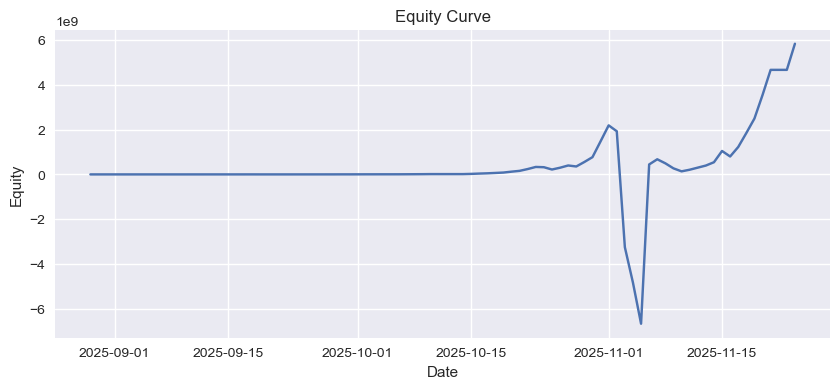

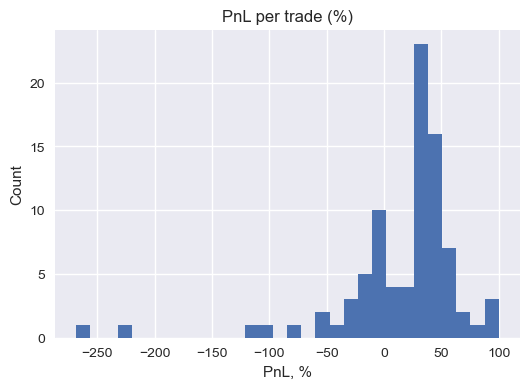

Total trades: 86
Total return: 58331.645408025215
Max drawdown: -4.045
Win rate: 0.6976744186046512
Average win (pnl_pct): 0.4016369518700623
Average loss (pnl_pct): -0.5498115148208591
Sharpe ratio (annualized): 4.275961052437504


In [4]:
trades_df = pd.DataFrame(trades)

if trades_df.empty:
    print("No trades")
else:
    trades_df = trades_df.sort_values("entry_time").reset_index(drop=True)
    trades_df["equity"] = INITIAL_CAPITAL * (1 + trades_df["pnl_pct"]).cumprod()
    trades_df["pnl_pct_pct"] = trades_df["pnl_pct"] * 100.0

    equity_points = pd.DataFrame(
        {
            "time": [trades_df["entry_time"].min()] + list(trades_df["exit_time"]),
            "equity": [INITIAL_CAPITAL] + list(trades_df["equity"]),
        }
    ).sort_values("time")

    equity_curve = equity_points.set_index("time").resample("1D").ffill().dropna()
    equity_curve["cummax"] = equity_curve["equity"].cummax()
    equity_curve["drawdown"] = equity_curve["equity"] / equity_curve["cummax"] - 1.0

    max_drawdown = float(equity_curve["drawdown"].min()) if not equity_curve.empty else np.nan
    total_return = float(equity_curve["equity"].iloc[-1] / INITIAL_CAPITAL - 1.0) if not equity_curve.empty else np.nan

    num_trades = len(trades_df)
    wins = trades_df[trades_df["pnl_pct"] > 0]
    losses = trades_df[trades_df["pnl_pct"] < 0]

    win_rate = len(wins) / num_trades if num_trades > 0 else np.nan
    avg_win = wins["pnl_pct"].mean() if not wins.empty else np.nan
    avg_loss = losses["pnl_pct"].mean() if not losses.empty else np.nan

    returns = equity_curve["equity"].pct_change().dropna()
    if len(returns) > 1 and returns.std() > 0:
        rf_daily = (1 + RISK_FREE_RATE) ** (1 / 252) - 1
        excess = returns - rf_daily
        sharpe_ratio = float(np.sqrt(252) * excess.mean() / excess.std())
    else:
        sharpe_ratio = np.nan

    display(trades_df.head(20))

    plt.figure(figsize=(10, 4))
    plt.plot(equity_curve.index, equity_curve["equity"])
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(trades_df["pnl_pct_pct"], bins=30)
    plt.title("PnL per trade (%)")
    plt.xlabel("PnL, %")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

    print("Total trades:", num_trades)
    print("Total return:", total_return)
    print("Max drawdown:", max_drawdown)
    print("Win rate:", win_rate)
    print("Average win (pnl_pct):", avg_win)
    print("Average loss (pnl_pct):", avg_loss)
    print("Sharpe ratio (annualized):", sharpe_ratio)